# Peak PIPM Distribution Model.
This file is an attempt to clean up the original code for this model. 

Started: 3.7.18 -- 
Last Update: 3.7.18

In [6]:
# load packages
import pandas as pd
import numpy as np
from IPython import display

import warnings
warnings.filterwarnings('ignore')
from sklearn import linear_model, ensemble, feature_selection, model_selection, metrics
from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')
sns.set_style('white')
plt.rcParams['figure.figsize'] = 15,10

# Make all columns in dataframe output visible, and display more rows/list items.
pd.options.display.max_columns = 999
pd.options.display.max_seq_items=200

# import data
totals = pd.DataFrame(pd.read_csv('NCAA Player Stats - Totals.csv'))
advanced = pd.DataFrame(pd.read_csv('NCAA Player Stats - Advanced.csv'))
all_player_info = pd.DataFrame(pd.read_csv('RealGM PlayerInfo.csv'))
rsci = pd.DataFrame(pd.read_csv('RSCI.csv'))
nba = pd.DataFrame(pd.read_csv('Seasons_Stats.csv'))

# Merge totals and advanced
cols_to_merge = advanced.columns.difference(totals.columns).tolist()
df = pd.merge(totals, advanced[cols_to_merge], left_index=True, right_index=True, how='outer')

# Merge player info onto general stats df from last step.
df = pd.merge(df, all_player_info, on='Player ID', how='left')


### Merge RSCI rankings into df.
# There are multiple players in df with the same name as some of the players in RSCI. To avoid giving the wrong players a RSCI
# ranking, I will merge on the players' names and their assumed first college season with an intermidiate dataframe.

# Because 'Season' column in df is missing values, I'll make my own 'Season' column by manipulating '2Y Season'.
df.drop('Season', axis=1, inplace=True)
df['Season'] = pd.to_numeric(df['2Y Season'].str[0:2] + df['2Y Season'].str[-2:])
df['Season'].replace(1900, 2000, inplace=True)

# Create 'Season' column in rsci from 'Year' string. Add 1
rsci['Season'] = pd.to_numeric(rsci['Year'].str.split('/').str[-2]) + 1

# Create 'Player Name' column in rsci from 'Player'.
rsci['Player Name'] = rsci['Player'].str.strip()

# Intermediate dataframe.
interm_df = df[['Player Name', 'Player ID', 'Season']]
interm_df = interm_df.groupby('Player ID').first().reset_index()
interm_df = interm_df.merge(rsci[['Player Name', 'Season', 'RSCI']], 
                            how='left', on=['Player Name', 'Season'])

# add RSCI data to main dataframe, df.
df = pd.merge(df, interm_df[['Player ID', 'RSCI']], how='left', on='Player ID')

### Add Will's BPM calc'd from RealGM and KenPom
willbpm = pd.DataFrame(pd.read_csv('WillsBPM.csv'))

df = pd.merge(df, willbpm, how='left', on=['Player ID', 'Season'])

# drop unwanted columns 
col_drop = ['2Y Season', 'Table', 'League', 'Conference', 'Team Name', 'Team Num', 'Team Polished', 
            'Class', 'Player ID w Class', 'Status', 'Team w Stuff', 'Name', 'School (college)', 'Birthday Text', 
            'Hometown', 'High School', 'Class w Trans RS']
df.drop(col_drop, axis=1, inplace=True)


# Convert numeric columns to a numeric data type.
continuous_cols = ['GP', 'GS', 'MIN','FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OFF', 'DEF', 'TRB', 'AST', 
                   'STL', 'BLK', 'PF', 'TOV', 'PTS', 'AST%', 'BLK%', 'DRB%', 'DRtg', 'ORB%', 'ORtg', 'PER', 'PPR', 'PPS', 'STL%',
                   'TOV%', 'TRB%', 'TS%', 'Total S %', 'USG%', 'eFG%']
for column in continuous_cols:
    df[column] = pd.to_numeric(df[column], errors='coerce')

# Map old positions to new positions and create new positions column.
guards = ['PG', 'G']
wings = ['SG', 'GF', 'F-G', 'SF', 'G-F']
bigs = ['F', 'PF', 'FC', 'F-C', 'C-F', 'C']

df['Position'] = np.where(df['Position'].isin(guards), 'G',
                         np.where(df['Position'].isin(wings), 'W',
                                 np.where(df['Position'].isin(bigs), 'B', None)))

# Drop players without a position.
df = df[pd.notnull(df['Position'])]

# Make temporary dataframe with height and position data.
ht_pos_df = df[['Height', 'Position']]

# Remove NANs and '-' values.
ht_pos_df = ht_pos_df[ht_pos_df['Height'] != '-']
ht_pos_df.dropna(axis=0, how='any', inplace=True)

# Make numeric height column in inches.
ht_pos_df['height_inches'] = pd.to_numeric(ht_pos_df['Height'].str[0]) * 12 + pd.to_numeric(ht_pos_df['Height'].str.split('-').str[1])
ht_pos_df.drop('Height', axis=1, inplace=True)

# Find average height by position.
pos_ht_mean = ht_pos_df.groupby('Position').mean()

# Replace '-' in Height column of df.
df['Height'].replace('-', np.nan, inplace=True)


# Convert hieght to inches.
df['height_inches'] = pd.to_numeric(
    df['Height'].str[0]) * 12 + pd.to_numeric(
    df['Height'].str.split('-').str[1])

# Make dictionary of height averages by position.
pos_ht_dict = pos_ht_mean.to_dict()['height_inches']

# Fill NANs in height column with position averages from pos_ht_mean dataframe.
df['filled_ht'] = np.where(np.isfinite(df['height_inches']), df['height_inches'],
                           np.where(df['Position'] == 'B', pos_ht_dict['B'],
                                   np.where(df['Position'] == 'G', pos_ht_dict['G'],
                                                   np.where(df['Position'] == 'W', pos_ht_dict['W'], None))))

# Drop unccessary height cols and rename filled col.
df.drop(['height_inches', 'Height'], axis=1, inplace=True)
df['Height'] = df['filled_ht']
df.drop('filled_ht', axis=1, inplace=True)

# Convert Height to numeric data type.
df['Height'] = pd.to_numeric(df['Height'])

# Get rid of '-' in column.
df['Birthday Code'].replace('-', np.nan, inplace=True)

# Get age from Birthday Code.
df['Age'] = (df['Season'] - pd.to_numeric(
    df['Birthday Code'].str[:4])) - ((((pd.to_numeric(
    df['Birthday Code'].str[4:6]) - 1) * 30.4375) + pd.to_numeric(
    df['Birthday Code'].str[6:])) / 365.25)

# To fill in missing ages, give first season the average age of all first year players, and so on.
df['season_num'] = pd.to_numeric(
    df['Player Season Num'].str.split('_').str[3].str[:-1]).astype(int)

for num in range(1, 11):
    num_age_mean = df[df['season_num'] == num]['Age'].mean()
    df.loc[df.season_num == num, 'Age'] = df.loc[
        df.season_num == num, 'Age'].fillna(num_age_mean)
    
# Drop birthday code and season_num.
df.drop(['Birthday Code', 'season_num', 'Player Season Num'], axis=1, inplace=True)

# List of player ids who are too young and too old.
young_plyrids = df[df['Age'] < 18]['Player ID'].tolist()
old_plyrids = df[df['Age'] > 25]['Player ID'].tolist()

rmv_playerids = young_plyrids + old_plyrids

# Remove players in above lists from dataframe.
df = df[~df['Player ID'].isin(rmv_playerids)]

# Remove seasons with missing minutes values (which usually means all basketball stat values are missing too.)
df = df[np.isfinite(df['MIN'])]
df = df[df['MIN'] > 0]

# List of player ids that have missing rates in any season.
playerids_missing_rates = df[~np.isfinite(df['AST%'])]['Player ID'].tolist()

# Remove players in above list from dataframe.
df = df[-df['Player ID'].isin(playerids_missing_rates)]

# Fill missing FGA values
df['FGA'].fillna(0, inplace=True)

# ORB% wasn't scraped properly. Remove the column.
df.drop('ORB%', axis=1, inplace=True)

# Remove anyone without a listed weight (there aren't many at all.)
df = df[pd.notnull(df['Weight'])]

# Find rsci max value.
rsci_max = df['RSCI'].max()

# Fill with maxRSCI + 1.
df['RSCI'].fillna(rsci_max + 1, inplace=True)

# Remove players who play after 2014.
plyrs_14 = df[df['Season'] > 2014]['Player ID'].tolist()
df = df[-df['Player ID'].isin(plyrs_14)]

# Make ratio of games started per game played.
df['GS:GP'] = df['GS'] / df['GP']

# MIN/GP
df['MIN:GP'] = df['MIN'] / df['GP']

# usg% * TS%
df['USGxTS'] = df['USG%'] * df['TS%']

# Stl and blk
df['STLK'] = df['STL'] + df['BLK']
df['STLK%'] = df['STL%'] + df['BLK%']

# PF/MIN, PF/STLK
df['PF:MIN'] = df['PF'] / df['MIN']
df['PF:STLK'] = df['PF'] / df['STLK']

# Add FT rate
df['FTRate'] = df['FTA'] / df['FGA']

# Remove inf values.
df = df[-df.isin([np.inf])]

### Predict and add DBPM prediction to data set.

# import dbpm sample data with indicators.
dbpm = pd.DataFrame(pd.read_csv('DBPMdata.csv'))

# Map old positions to new positions and create new positions column.
dbpm = dbpm[dbpm['Pos'].isin(['F', 'G', 'C'])]

dbpm['Pos'] = np.where(dbpm['Pos'].isin(['F', 'C']), 1, 0)

# assign indicators and target variable.
dbpm_x= ['G', 'MP', 'PER', 'TS%', 'eFG%', 'DRB%', 'TRB%', 'AST%',
       'STL%', 'BLK%', 'TOV%', 'USG%', 'ORtg', 'DRtg', 'BPM']

dbpm_y= ['DBPM']

# set dtypes to number types.
for col in dbpm_x:
    dbpm[col] = pd.to_numeric(dbpm[col], errors='coerce')

dbpm['DBPM'] = pd.to_numeric(dbpm['DBPM'], errors='coerce')

dbpm.dropna(inplace=True)

# I already compared linear regression against other model types.
### Linear Regression
lr = linear_model.LinearRegression()
lr.fit(dbpm[dbpm_x], dbpm[dbpm_y])


### Prep columns to fit DBPM prediction model above.
temp_df_cols = ['Player ID', 'Season', 'GP', 'MIN', 'PER', 'TS%', 'eFG%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%',
                'TOV%', 'USG%', 'ORtg', 'DRtg', 'BPM']
temp_df_dbpm = df[temp_df_cols]

# Create missing cols for dbpm predictions.
temp_df_dbpm['G'] = temp_df_dbpm['GP']
temp_df_dbpm.drop('GP', axis=1, inplace=True)

temp_df_dbpm['MP'] = temp_df_dbpm['MIN']
temp_df_dbpm.drop('MIN', axis=1, inplace=True)
   
# Predict DBPM
temp_df_dbpm['pDBPM'] = lr.predict(temp_df_dbpm[dbpm_x])

# Merge pDBPM into df.
temp_df_dbpm = temp_df_dbpm[['Player ID', 'Season', 'pDBPM']]

df = df.merge(temp_df_dbpm, how='left', on=['Player ID', 'Season'])

#### Percentiles for stats by position.

# variables to adjust
cols = ['Player ID', 'Season', 'AST%', 'BLK%', 'DRB%', 'DRtg',
       'ORtg', 'PER', 'PPR', 'PPS', 'STL%', 'TOV%', 'TRB%', 'TS%', 'Total S %',
       'USG%', 'eFG%', 'BPM', 'Weight', 'Height', 'USGxTS', 
        'STLK', 'STLK%', 'PF:MIN', 'PF:STLK', 'pDBPM', 'FTRate']

# temporary dfs by position
bigs = df[df['Position'] == 'B'][cols]
guards = df[df['Position'] == 'G'][cols]
wings = df[df['Position'] == 'W'][cols]

# Add percentile columns.
pos_dfs = [bigs, guards, wings]

for pos_df in pos_dfs:
    for col in cols[2:]:
        pos_df[col + '_ppctl'] = pos_df[col].rank(pct=True)

# Merge the percentile cols back to df.
ppctl_cols = ['Player ID', 'Season'] + [col + '_ppctl' for col in cols[2:]]

mbigs = bigs[ppctl_cols]
mguards = guards[ppctl_cols]
mwings = wings[ppctl_cols]

new_pos_dfs = [mbigs, mguards, mwings]

all_pos = pd.concat(new_pos_dfs)

df = df.merge(all_pos, how='left', on=['Player ID', 'Season'])

# Aggregate shooting data, to give career totals that are attempt-weighted.
shots_by_pos = df.groupby('Position')[['FGM', 'FGA', 'FG%','3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%']].mean()


df['rFGM'] = np.where(df['Position'] == 'B', (shots_by_pos.loc['B','FGA'] * .1 * shots_by_pos.loc['B', 'FG%']) + df['FGM'],
                           np.where(df['Position'] == 'G', (shots_by_pos.loc['G','FGA'] * .1 * shots_by_pos.loc['G', 'FG%']) + df['FGM'],
                                    (shots_by_pos.loc['W','FGA'] * .1 * shots_by_pos.loc['W', 'FG%']) + df['FGM']))

df['rFGA'] = np.where(df['Position'] == 'B', (shots_by_pos.loc['B','FGA'] * .1) + df['FGA'],
                           np.where(df['Position'] == 'G', (shots_by_pos.loc['G','FGA'] * .1) + df['FGA'],
                                   (shots_by_pos.loc['W','FGA'] * .1) + df['FGA']))

df['r3PM'] = np.where(df['Position'] == 'B', (shots_by_pos.loc['B','3PA'] * .1 * shots_by_pos.loc['B', '3P%']) + df['3PM'],
                           np.where(df['Position'] == 'G', (shots_by_pos.loc['G','3PA'] * .1 * shots_by_pos.loc['G', '3P%']) + df['3PM'],
                                   (shots_by_pos.loc['W','3PA'] * .1 * shots_by_pos.loc['W', '3P%']) + df['3PM']))

df['r3PA'] = np.where(df['Position'] == 'B', (shots_by_pos.loc['B','3PA'] * .1) + df['3PA'],
                           np.where(df['Position'] == 'G', (shots_by_pos.loc['G','3PA'] * .1) + df['3PA'],
                                   (shots_by_pos.loc['W','3PA'] * .1) + df['3PA']))

df['rFTM'] = np.where(df['Position'] == 'B', (shots_by_pos.loc['B','FTA'] * .1 * shots_by_pos.loc['B', 'FT%']) + df['FTM'],
                           np.where(df['Position'] == 'G', (shots_by_pos.loc['G','FTA'] * .1 * shots_by_pos.loc['G', 'FT%']) + df['FTM'],
                                   (shots_by_pos.loc['W','FTA'] * .1 * shots_by_pos.loc['W', 'FT%']) + df['FTM']))

df['rFTA'] = np.where(df['Position'] == 'B', (shots_by_pos.loc['B','FTA'] * .1) + df['FTA'],
                           np.where(df['Position'] == 'G', (shots_by_pos.loc['G','FTA'] * .1) + df['FTA'],
                                   (shots_by_pos.loc['W','FTA'] * .1 ) + df['FTA']))

df.reset_index(drop=True, inplace=True)

### Introduce 2014-2018 Data ###
# Because we need to adjust the 2014-2018 data in the same way that we adjust the historical data, 
# we will import the 2014-18 data now.

### Data Prep for 2014-18 prospects
df_18 = pd.DataFrame(pd.read_csv('2014-18PlayerInfoAndStats.csv'))
df_18.drop('Unnamed: 0', axis=1, inplace=True)
df_18.drop_duplicates(inplace=True)

# Make 'Season' col.
df_18['2y season'] = df_18['2y season'].astype(str)
df_18 = df_18[df_18['2y season'] != 'CAREER']
df_18['Season'] = pd.to_numeric(df_18['2y season'].str[0:2] + df_18['2y season'].str[-2:])
df_18['Season'].replace(1900, 2000, inplace=True)

# Fix Zhaire Smith's Birthday Code. (When I changed the source of the data and how I scraped it I think it made the 'Birthday Code' col a number, not a string. So the below code that gives the average age of the season number might be broken. For now it doesn't affect any of the players that I care about, but I should fix later.)
df_18.at[14133, 'Birthday Code'] = 19990604


# import RSCI 2011-2017 data
rsci18 = pd.DataFrame(pd.read_csv('2018RSCI.csv'))

# Create merging key: season col for rsci18 df.
rsci18['Season'] = pd.to_numeric(rsci18['Year'].str.split('/').str[-2]) + 1

# Create 'Player Name' col
rsci18['Player Name'] = rsci18['Player'].str.strip().str.lower()

# Intermediate dataframe.
fname = df_18['Player ID'].str.split('/').str[1].str.split('-').str[0]
lname = df_18['Player ID'].str.split('/').str[1].str.split('-').str[1]
df_18['Player Name'] = fname.str.cat(lname, sep=' ').str.lower()

interm18_df = df_18[['Player Name', 'Player ID', 'Season']]
interm18_df = interm18_df.groupby('Player ID').first().reset_index()
interm18_df = interm18_df.merge(rsci18[['Player Name', 'Season', 'RSCI']], 
                            how='left', on=['Player Name', 'Season'])

# add RSCI data to main dataframe, df.
df_18 = pd.merge(df_18, interm18_df[['Player ID', 'RSCI']], how='left', on='Player ID')
df_18['RSCI'] = df_18['RSCI'].fillna(354)

# Fix some column names.
# df_18['ORtg'] = df_18['Ortg']
# df_18['Total S %'] = df_18['Total S%']

# Drop unimportant columns
df_18.drop(['2y season', 'class'], axis=1, inplace=True)

# Convert numeric columns to a numeric data type.
continuous_cols = ['GP', 'GS', 'MIN','FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OFF', 'DEF', 'TRB', 'AST', 
                   'STL', 'BLK', 'PF', 'TOV', 'PTS', 'AST%', 'BLK%', 'DRB%', 'DRtg', 'ORB%', 'ORtg', 'PER', 'PPR', 'PPS', 'STL%',
                   'TOV%', 'TRB%', 'TS%', 'Total S %', 'USG%', 'eFG%']
for column in continuous_cols:
    df_18[column] = pd.to_numeric(df_18[column], errors='coerce')
    
# Map old positions to new positions and create new positions column.
guards = ['PG', 'G']
wings = ['SG', 'GF', 'F-G', 'SF', 'G-F']
bigs = ['F', 'PF', 'FC', 'F-C', 'C-F', 'C']

df_18['Position'] = np.where(df_18['Position'].isin(guards), 'G',
                            np.where(df_18['Position'].isin(wings), 'W',
                                    np.where(df_18['Position'].isin(bigs), 'B', None)))

# Drop players without a position.
df_18 = df_18[pd.notnull(df_18['Position'])]

# Make temporary dataframe with height and position data.
ht_pos_df_18 = df_18[['Height', 'Position']]

# Remove NANs and '-' values.
ht_pos_df_18 = ht_pos_df_18[ht_pos_df_18['Height'] != '-']
ht_pos_df_18.dropna(axis=0, how='any', inplace=True)

# Make numeric height column in inches.
ht_pos_df_18['height_inches'] = pd.to_numeric(ht_pos_df_18['Height'].str[0]) * 12 + pd.to_numeric(ht_pos_df_18['Height'].str.split('-').str[1])
ht_pos_df_18.drop('Height', axis=1, inplace=True)

# Find average height by position.
pos_ht_mean = ht_pos_df_18.groupby('Position').mean()

# Replace '-' in Height column of df_18.
df_18['Height'].replace('-', np.nan, inplace=True)


# Convert hieght to inches.
df_18['height_inches'] = pd.to_numeric(
    df_18['Height'].str[0]) * 12 + pd.to_numeric(
    df_18['Height'].str.split('-').str[1])

# Make dictionary of height averages by position.
pos_ht_dict = pos_ht_mean.to_dict()['height_inches']

# Fill NANs in height column with position averages from pos_ht_mean dataframe.
df_18['filled_ht'] = np.where(np.isfinite(df_18['height_inches']), df_18['height_inches'],
                           np.where(df_18['Position'] == 'B', pos_ht_dict['B'],
                                   np.where(df_18['Position'] == 'G', pos_ht_dict['G'],
                                           np.where(df_18['Position'] == 'W', pos_ht_dict['W'], None))))

# Drop unccessary height cols and rename filled col.
df_18.drop(['height_inches', 'Height'], axis=1, inplace=True)
df_18['Height'] = df_18['filled_ht']
df_18.drop('filled_ht', axis=1, inplace=True)

# Convert Height to numeric data type.
df_18['Height'] = pd.to_numeric(df_18['Height'])


# Replace bad values in Birthday Code.
df_18['Birthday Code'] = df_18['Birthday Code'].astype(str)
df_18['Birthday Code'].replace('-', np.nan, inplace=True)
df_18['Birthday Code'].replace('19400101', np.nan, inplace=True)

# Get age from Birthday Code.
df_18['Age'] = (df_18['Season'] - pd.to_numeric(
    df_18['Birthday Code'].str[:4])) - ((((pd.to_numeric(
    df_18['Birthday Code'].str[4:6]) - 1) * 30.4375) + pd.to_numeric(
    df_18['Birthday Code'].str[6:])) / 365.25)

# Add Player Season Num column.
df_18['season_num'] = np.nan
df_18['season_num'] = np.where((df_18['Player ID'] == df_18['Player ID'].shift(5)) & (df_18['Player ID'] != df_18['Player ID'].shift(6)), 6, df_18['season_num'])
df_18['season_num'] = np.where((df_18['Player ID'] == df_18['Player ID'].shift(4)) & (df_18['Player ID'] != df_18['Player ID'].shift(5)), 5, df_18['season_num'])   
df_18['season_num'] = np.where((df_18['Player ID'] == df_18['Player ID'].shift(3)) & (df_18['Player ID'] != df_18['Player ID'].shift(4)), 4, df_18['season_num'])
df_18['season_num'] = np.where((df_18['Player ID'] == df_18['Player ID'].shift(2)) & (df_18['Player ID'] != df_18['Player ID'].shift(3)), 3, df_18['season_num'])
df_18['season_num'] = np.where((df_18['Player ID'] == df_18['Player ID'].shift(1)) & (df_18['Player ID'] != df_18['Player ID'].shift(2)), 2, df_18['season_num'])
df_18['season_num'] = np.where(df_18['Player ID'] != df_18['Player ID'].shift(1), 1, df_18['season_num'])

df_18 = df_18[pd.notnull(df_18['season_num'])]

# To fill in missing ages, give first season the average age of all first year players, and so on.
for num in range(1, 11):
    num_age_mean = df_18[df_18['season_num'] == num]['Age'].mean()
    df_18.loc[df_18.season_num == num, 'Age'] = df_18.loc[
        df_18.season_num == num, 'Age'].fillna(num_age_mean)
    
# Drop birthday code and season_num.
df_18.drop(['Birthday Code', 'season_num'], axis=1, inplace=True)

# Make ratio of games started per game played.
df_18['GS:GP'] = df_18['GS'] / df_18['GP']

# MIN/GP
df_18['MIN:GP'] = df_18['MIN'] / df_18['GP']

# usg% * TS%, usg/ts, ts/usg.
df_18['USGxTS'] = df_18['USG%'] * df_18['TS%']

# Stl and blk
df_18['STLK'] = df_18['STL'] + df_18['BLK']
df_18['STLK%'] = df_18['STL%'] + df_18['BLK%']

# PF/MIN, PF/STLK
df_18['PF:MIN'] = df_18['PF'] / df_18['MIN']
df_18['PF:STLK'] = df_18['PF'] / df_18['STLK']

# FTRate
df_18['FTRate'] = df_18['FTA'] / df_18['FGA']


df_18 = df_18[np.isfinite(df_18['MIN'])]
df_18 = df_18[df_18['MIN'] > 0]
df_18 = df_18[np.isfinite(df_18['ORB%'])]
df_18 = df_18[np.isfinite(df_18['Weight'])]

# Read BPM data in.
bpm18 = pd.DataFrame(pd.read_csv('2018BPM.csv'))
bpm1417 = pd.DataFrame(pd.read_csv('2010-2017 BPM Database.csv'))
bpm1418 = pd.concat([bpm18, bpm1417], ignore_index=True)

### Clean columns for merge.
bpm1418 = bpm1418[['Player', 'Season', 'BPM', 'DBPM']]
bpm1418.dropna(inplace=True)
bpm1418 = bpm1418.reset_index(drop=True)

# Player Name col.
bpm1418['Player Name'] = bpm1418['Player'].str.split('\\').str[0].str.lower()
bpm1418['Player Name'] = bpm1418['Player Name'].str.replace('.', '')
bpm1418['Player Name'] = bpm1418['Player Name'].str.replace('-', ' ')
bpm1418['Player Name'] = bpm1418['Player Name'].str.replace('\'', '')
bpm1418['Player Name'] = bpm1418['Player Name'].str.split().str[:2].str.join(' ')

# Season col.
bpm1418['Season'] = bpm1418['Season'].astype(str)
bpm1418 = bpm1418[bpm1418['Season'] != 'Season']
bpm1418['Season'] = pd.to_numeric(bpm1418['Season'].str[0:2] + bpm1418['Season'].str[-2:])
bpm1418['Season'].replace(1900, 2000, inplace=True)

# BPM data type.
bpm1418['BPM'] = bpm1418['BPM'].astype(float)
bpm1418['DBPM'] = bpm1418['DBPM'].astype(float)

# Merge BPM, DBPM
interm1418_df = df_18[['Player Name', 'Player ID', 'Season']]
interm1418_df = interm1418_df.merge(bpm1418[['Player Name', 'Season', 'BPM', 'DBPM']], how='left', on=['Player Name', 'Season'], indicator=True)

df_18 = pd.merge(df_18, interm1418_df[['Player ID', 'Season', 'BPM', 'DBPM']], how='left', on=['Player ID', 'Season'])
df_18 = df_18[pd.notnull(df_18['BPM'])]

df_18['pDBPM'] = df_18['DBPM']


#### Percentiles for stats by position.

# variables to adjust
cols = ['Player ID', 'Season', 'AST%', 'BLK%', 'DRB%', 'DRtg',
       'ORtg', 'PER', 'PPR', 'PPS', 'STL%', 'TOV%', 'TRB%', 'TS%', 'Total S %',
       'USG%', 'eFG%', 'BPM', 'Height', 'Weight', 'USGxTS', 'STLK', 'STLK%', 'PF:MIN', 'PF:STLK', 
        'FTRate', 'pDBPM']

# temporary dfs by position
bigs = df[df['Position'] == 'B'][cols]
guards = df[df['Position'] == 'G'][cols]
wings = df[df['Position'] == 'W'][cols]

# Add 2018 data to total pool
bigs18 = df_18[df_18['Position'] == 'B'][cols]
guards18 = df_18[df_18['Position'] == 'G'][cols]
wings18 = df_18[df_18['Position'] == 'W'][cols]

tot_bigs = pd.concat([bigs, bigs18], keys = ['train', 'eighteen'])
tot_guards = pd.concat([guards, guards18], keys = ['train', 'eighteen'])
tot_wings = pd.concat([wings, wings18], keys = ['train', 'eighteen'])

# Add percentile columns.
tot_pos_dfs = [tot_bigs, tot_guards, tot_wings]

for tot_pos_df in tot_pos_dfs:
    for col in cols[2:]:
        tot_pos_df[col + '_ppctl'] = tot_pos_df[col].rank(pct=True)
        
# Merge the percentile cols back to df.
ppctl_cols = ['Player ID', 'Season'] + [col + '_ppctl' for col in cols[2:]]

mbigs18 = tot_bigs.loc['eighteen'][ppctl_cols]
mguards18 = tot_guards.loc['eighteen'][ppctl_cols]
mwings18 = tot_wings.loc['eighteen'][ppctl_cols]

new_pos_dfs18 = [mbigs18, mguards18, mwings18]

all_pos18 = pd.concat(new_pos_dfs18)

df_18 = df_18.merge(all_pos18, how='left', on=['Player ID', 'Season'])


### Regress shot%s to mean.
shots_by_pos = df_18.groupby('Position')[['FGM', 'FGA', 'FG%','3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%']].mean()


df_18['rFGM'] = np.where(df_18['Position'] == 'B', (shots_by_pos.loc['B','FGA'] * .1 * shots_by_pos.loc['B', 'FG%']) + df_18['FGM'],
                           np.where(df_18['Position'] == 'G', (shots_by_pos.loc['G','FGA'] * .1 * shots_by_pos.loc['G', 'FG%']) + df_18['FGM'],
                                   (shots_by_pos.loc['W','FGA'] * .1 * shots_by_pos.loc['W', 'FG%']) + df_18['FGM']))

df_18['rFGA'] = np.where(df_18['Position'] == 'B', (shots_by_pos.loc['B','FGA'] * .1) + df_18['FGA'],
                           np.where(df_18['Position'] == 'G', (shots_by_pos.loc['G','FGA'] * .1) + df_18['FGA'],
                                   (shots_by_pos.loc['W','FGA'] * .1) + df_18['FGA']))

df_18['r3PM'] = np.where(df_18['Position'] == 'B', (shots_by_pos.loc['B','3PA'] * .1 * shots_by_pos.loc['B', '3P%']) + df_18['3PM'],
                           np.where(df_18['Position'] == 'G', (shots_by_pos.loc['G','3PA'] * .1 * shots_by_pos.loc['G', '3P%']) + df_18['3PM'],
                                   (shots_by_pos.loc['W','3PA'] * .1 * shots_by_pos.loc['W', '3P%']) + df_18['3PM']))

df_18['r3PA'] = np.where(df_18['Position'] == 'B', (shots_by_pos.loc['B','3PA'] * .1) + df_18['3PA'],
                           np.where(df_18['Position'] == 'G', (shots_by_pos.loc['G','3PA'] * .1) + df_18['3PA'],
                                   (shots_by_pos.loc['W','3PA'] * .1) + df_18['3PA']))

df_18['rFTM'] = np.where(df_18['Position'] == 'B', (shots_by_pos.loc['B','FTA'] * .1 * shots_by_pos.loc['B', 'FT%']) + df_18['FTM'],
                           np.where(df_18['Position'] == 'G', (shots_by_pos.loc['G','FTA'] * .1 * shots_by_pos.loc['G', 'FT%']) + df_18['FTM'],
                                   (shots_by_pos.loc['W','FTA'] * .1 * shots_by_pos.loc['W', 'FT%']) + df_18['FTM']))

df_18['rFTA'] = np.where(df_18['Position'] == 'B', (shots_by_pos.loc['B','FTA'] * .1) + df_18['FTA'],
                           np.where(df_18['Position'] == 'G', (shots_by_pos.loc['G','FTA'] * .1) + df_18['FTA'],
                                   (shots_by_pos.loc['W','FTA'] * .1 ) + df_18['FTA']))

### Age Adjust
# Make age bins
bins = np.arange(18, 24.25, .25)
age_bins = pd.cut(df['Age'], bins)
mean_age_df = df.groupby(age_bins).mean().dropna()

# Make x axis for age groups. (Mid-point of each bin.)
x_age_groups = np.arange(18.125, 24, 0.25)[2:]

# columns to age adjust:
col_age_adj = ['GP', 'GS', 'MIN', 'FGM', 'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OFF', 'DEF',
                   'TRB', 'AST', 'STL', 'BLK', 'PF', 'TOV', 'PTS', 'AST%', 'BLK%', 'DRB%', 'DRtg', 'ORtg', 'PER', 'PPR',
                   'PPS', 'STL%', 'TOV%', 'TRB%', 'TS%', 'Total S %', 'USG%', 'eFG%', 'BPM', 'GS:GP', 'MIN:GP',
                   'USGxTS', 'STLK', 'STLK%', 'PF:MIN', 'PF:STLK', 'FTRate', 'pDBPM', 'rFGM', 'rFGA', 'r3PM', 'r3PA',
                   'rFTM', 'rFTA', 'AST%_ppctl', 'BLK%_ppctl', 'DRB%_ppctl', 'DRtg_ppctl', 'ORtg_ppctl', 'PER_ppctl',
                   'PPR_ppctl', 'PPS_ppctl', 'STL%_ppctl', 'TOV%_ppctl', 'TRB%_ppctl', 'TS%_ppctl', 'Total S %_ppctl',
                   'USG%_ppctl', 'eFG%_ppctl', 'BPM_ppctl', 'USGxTS_ppctl', 'STLK_ppctl', 'STLK%_ppctl', 'PF:MIN_ppctl',
                   'PF:STLK_ppctl', 'FTRate_ppctl', 'pDBPM_ppctl']

## Age ajustments.
# iterate of columns to adjust.
for col in col_age_adj:
    # assign mean values by age bin to y.
    y = np.asarray(mean_age_df[col])[2:]

    fit = np.polyfit(x_age_groups, y, deg=2)
   
    #  Create new age-adjusted col. 
    mean_19 = fit[0] * 19 ** 2 + fit[1] * 19 + fit[2]
    df['age_' + col] = (df[col] * mean_19) / (fit[0] * df['Age'] ** 2 + fit[1] * df['Age'] + fit[2])
    df_18['age_' + col] = (df_18[col] * mean_19) / (fit[0] * df_18['Age'] ** 2 + fit[1] * df_18['Age'] + fit[2])

df.reset_index(drop=True, inplace=True)

### Prepare for weighted average of rate stats by col of season MIN fraction of total career minutes.
tot_min = df.groupby('Player ID')['MIN'].sum().reset_index()
tot_min['TotMIN'] = tot_min['MIN']
tot_min.drop('MIN', axis=1, inplace=True)

df = df.merge(tot_min, how='left', on='Player ID')

df['SeasonMINfrac'] = df['MIN'] / df['TotMIN']

# Columns to weight by minutes.
cols_to_weight = ['age_AST%', 'age_BLK%', 'age_DRB%', 'age_DRtg', 'age_ORtg', 'age_PER', 'age_PPR', 'age_PPS', 'age_STL%', 
               'age_TOV%', 'age_TRB%', 'age_TS%', 'age_Total S %', 'age_USG%', 'age_eFG%', 'age_BPM', 'age_MIN:GP', 'age_USGxTS', 
               'age_FTRate', 'age_STLK%', 'age_PF:MIN', 'age_PF:STLK', 'age_pDBPM', 'age_AST%_ppctl', 
               'age_BLK%_ppctl', 'age_DRB%_ppctl', 'age_DRtg_ppctl', 'age_ORtg_ppctl', 'age_PER_ppctl', 'age_PPR_ppctl', 
               'age_PPS_ppctl', 'age_STL%_ppctl', 'age_TOV%_ppctl', 'age_TRB%_ppctl', 'age_TS%_ppctl', 'age_Total S %_ppctl', 
               'age_USG%_ppctl', 'age_eFG%_ppctl', 'age_BPM_ppctl', 'age_USGxTS_ppctl', 'age_FTRate_ppctl', 
               'age_STLK%_ppctl', 'age_PF:MIN_ppctl', 'age_PF:STLK_ppctl', 'age_pDBPM_ppctl']

for col in cols_to_weight:
    df[col] = df[col].astype(float)
    df[col] = df[col] * df['SeasonMINfrac']
    
wghted_avg_df = df.groupby('Player ID')[cols_to_weight].sum()


# Columns to average
cols_to_avg = ['MIN']

for col in cols_to_avg:
    df[col] = df[col].astype(float)

avg_df = df.groupby('Player ID')[cols_to_avg].mean()

# Calc college career shooting nums.
cols_to_total = ['age_rFGM', 'age_rFGA', 'age_r3PM', 'age_r3PA', 'age_rFTM', 'age_rFTA']
for col in cols_to_total:
    df[col] = df[col].astype(float)

tot_df = df.groupby('Player ID')[cols_to_total].sum()
tot_df['age_rFG%'] = tot_df['age_rFGM'] / tot_df['age_rFGA']
tot_df['age_r3P%'] = tot_df['age_r3PM'] / tot_df['age_r3PA']
tot_df['age_rFT%'] = tot_df['age_rFTM'] / tot_df['age_rFTA']
tot_df = tot_df[['age_rFG%', 'age_r3P%', 'age_rFT%']]

# Columns where final value is best/fine.
cols_last = ['Height', 'Weight', 'Height_ppctl', 'Weight_ppctl', 'Age', 'RSCI', 'Position', 'Season', 'Player Name']
last_df = df.groupby('Player ID')[cols_last].last()

# Add dummy variables for Position.
dummy_pos = pd.get_dummies(last_df['Position'], prefix='Pos')
last_df = pd.concat([last_df, dummy_pos], axis=1)
last_df.drop('Position', axis=1, inplace=True)

# Combine avg and last.
df = pd.merge(avg_df, tot_df, right_index=True, left_index=True)
df = pd.merge(df, last_df, right_index=True, left_index=True)
df = pd.merge(df, wghted_avg_df, right_index=True, left_index=True)

df_18.reset_index(drop=True, inplace=True)

### Prepare for weighted average of rate stats by col of season MIN fraction of total career minutes.
tot_min = df_18.groupby('Player ID')['MIN'].sum().reset_index()
tot_min['TotMIN'] = tot_min['MIN']
tot_min.drop('MIN', axis=1, inplace=True)

df_18 = df_18.merge(tot_min, how='left', on='Player ID')

df_18['SeasonMINfrac'] = df_18['MIN'] / df_18['TotMIN']

# Columns to weight by minutes.
cols_to_weight = ['age_AST%', 'age_BLK%', 'age_DRB%', 'age_DRtg', 'age_ORtg', 'age_PER', 'age_PPR', 'age_PPS', 'age_STL%', 
               'age_TOV%', 'age_TRB%', 'age_TS%', 'age_Total S %', 'age_USG%', 'age_eFG%', 'age_BPM', 'age_MIN:GP', 'age_USGxTS', 
               'age_FTRate', 'age_STLK%', 'age_PF:MIN', 'age_PF:STLK', 'age_pDBPM', 'age_AST%_ppctl', 
               'age_BLK%_ppctl', 'age_DRB%_ppctl', 'age_DRtg_ppctl', 'age_ORtg_ppctl', 'age_PER_ppctl', 'age_PPR_ppctl', 
               'age_PPS_ppctl', 'age_STL%_ppctl', 'age_TOV%_ppctl', 'age_TRB%_ppctl', 'age_TS%_ppctl', 'age_Total S %_ppctl', 
               'age_USG%_ppctl', 'age_eFG%_ppctl', 'age_BPM_ppctl', 'age_USGxTS_ppctl', 'age_FTRate_ppctl', 
               'age_STLK%_ppctl', 'age_PF:MIN_ppctl', 'age_PF:STLK_ppctl', 'age_pDBPM_ppctl']

for col in cols_to_weight:
    df_18[col] = df_18[col].astype(float)
    df_18[col] = df_18[col] * df_18['SeasonMINfrac']
    
wghted_avg_18 = df_18.groupby('Player ID')[cols_to_weight].sum()


# Columns to average
cols_to_avg = ['MIN']

for col in cols_to_avg:
    df_18[col] = df_18[col].astype(float)

avg_18 = df_18.groupby('Player ID')[cols_to_avg].mean()

# Calc college career shooting nums.
cols_to_total = ['age_rFGM', 'age_rFGA', 'age_r3PM', 'age_r3PA', 'age_rFTM', 'age_rFTA']
for col in cols_to_total:
    df_18[col] = df_18[col].astype(float)

tot_18 = df_18.groupby('Player ID')[cols_to_total].sum()
tot_18['age_rFG%'] = tot_18['age_rFGM'] / tot_18['age_rFGA']
tot_18['age_r3P%'] = tot_18['age_r3PM'] / tot_18['age_r3PA']
tot_18['age_rFT%'] = tot_18['age_rFTM'] / tot_18['age_rFTA']
tot_18 = tot_18[['age_rFG%', 'age_r3P%', 'age_rFT%']]

# Columns where final value is best/fine.
cols_last = ['Height', 'Weight', 'Height_ppctl', 'Weight_ppctl', 'Age', 'RSCI', 'Position']
last_18 = df_18.groupby('Player ID')[cols_last].last()

# Add dummy variables for Position.
dummy_pos = pd.get_dummies(last_18['Position'], prefix='Pos')
last_18 = pd.concat([last_18, dummy_pos], axis=1)
last_18.drop('Position', axis=1, inplace=True)

# Combine avg and last.
df_18 = pd.merge(wghted_avg_18, avg_18, right_index=True, left_index=True)
df_18 = pd.merge(df_18, tot_18, right_index=True, left_index=True)
df_18 = pd.merge(df_18, last_18, right_index=True, left_index=True)

df_18 = df_18[-df_18.isin([np.inf])]
df_18.dropna(inplace=True)

df_18 = df_18[df_18['MIN'] > 100]

## Target Variable: PIPM
We need to estimate a peak PIPM for those that have not had a chance reach it yet, or simply take their actual peak if it's bigger than any estimation. 

In [7]:
# import data
pipm = pd.DataFrame(pd.read_csv('PIPM Player Finder - Database.csv'))

# When a player is traded, 3 rows are dedicated to him: one for each team, and one total. 
# Remove the two team specific rows, and keep the total row.
pipm['rmv'] = np.where(pipm['Player'] == pipm['Player'].shift(1), False, True)
pipm = pipm[pipm['rmv'] == True]
pipm.drop('rmv', axis=1, inplace=True)

# Make 'Season' column just one number.
pipm['Season'] = pd.to_numeric(pipm['Season'].str[:2] + pipm['Season'].str[-2:])
pipm['Season'].replace(1900, 2000, inplace=True)

# Make 'MP' numeric.
pipm['MP'] = pd.to_numeric(pipm['MP'].str.replace(',', ''))

# We want only players that came into the league in the years 1996 through 2006, inclusive.
pipm = pipm[pipm['Season'] > 1994]

# Remove anyone who played in 1995 season.
plyrs_95 = pipm[pipm['Season'] == 1995]['Player'].tolist()
pipm = pipm[-pipm['Player'].isin(plyrs_95)]

# Keep players who played in 2005 season or before.
plyrs_06 = pipm[pipm['Season'] <= 2006]['Player'].tolist()
pipm = pipm[pipm['Player'].isin(plyrs_06)]

# Remove players that don't have 4 or more seasons.
plyrs_sns = pipm['Player'].value_counts()
keep = plyrs_sns[plyrs_sns >= 4].index.tolist()
pipm = pipm[pipm['Player'].isin(keep)].sort_values('Season')

### get 'Age' for rookie seasons from NBA data.
# import data. 
df_raw = pd.read_csv('Seasons_Stats.csv')

# Create a copy of the data.
df1 = df_raw.copy(deep=True)

# Drop imported index, col: 'Unnamed: 0'
df1.drop('Unnamed: 0', axis=1, inplace=True)

# Remove seasons before 1994.
df1 = df1[df1['Year'] >= 1994]

# When a player is traded, 3 rows are dedicated to him: one for each team, and one total. 
# Remove the two team specific rows, and keep the total row.
df1['rmv'] = np.where(df1['Player'] == df1['Player'].shift(1), False, True)
df1 = df1[df1['rmv'] == True]
df1.drop('rmv', axis=1, inplace=True)

# Remove everything but year, name, age.
df1 = df1[['Player', 'Year', 'Age']]

# We want only players that came into the league in 1995 or later.
# Remove anyone who played in 1995 season.
plyrs_95 = df1[df1['Year'] == 1995]['Player'].tolist()
df1 = df1[-df1['Player'].isin(plyrs_95)]

# prep to add age of rookie season to dataframe.
y1_age = pd.DataFrame(df1.groupby('Player')['Age'].min().reset_index())
y1_age['Player'] = np.where(y1_age['Player'].str[-1] == '*', y1_age['Player'].str[:-1], y1_age['Player'])
y1_age.set_index('Player', drop=True, inplace=True)

# Find the three year peak of each PIPM stat.
# Get list of each players PIPM stats, in consecutive order.
opipm4p_lsts = pipm.groupby('Player')['O-PIPM'].apply(list)
dpipm4p_lsts = pipm.groupby('Player')['D-PIPM'].apply(list)
pipm4p_lsts = pipm.groupby('Player')['PIPM'].apply(list)
mp4p_lsts = pipm.groupby('Player')['MP'].apply(list)
pipm4p_lsts = pd.concat([opipm4p_lsts, dpipm4p_lsts, pipm4p_lsts, mp4p_lsts], axis=1)

# Add col that gives num of seasons
pipm4p_lsts['NumSns'] = pipm4p_lsts['PIPM'].str.len()

# Add age.
pipm4p_lsts = pipm4p_lsts.merge(y1_age, how='left', right_index=True, left_index=True)
pipm4p_lsts.dropna(inplace=True)

# function that return 3 year peak
def peak(row):
    peak = -99
    mw_peak = -99
    for i in range(len(row['PIPM']) - 2):
        potential_peak = (row['PIPM'][i] + row['PIPM'][i + 1] + row['PIPM'][i + 2]) / 3
        if potential_peak > peak:
            peak = potential_peak
            
    return peak


# Apply peak to PIPM.
pipm4p_lsts['pPIPM'] = pipm4p_lsts.apply(peak, axis=1)


# Make year columns for opipm, dpipm, pipm, and mp. also multiply each by the fraction of total nba minutes as a measure of value. 
pipm4 = pipm4p_lsts[pipm4p_lsts['NumSns'] == 4]
pipm5 = pipm4p_lsts[pipm4p_lsts['NumSns'] == 5]
pipm6 = pipm4p_lsts[pipm4p_lsts['NumSns'] == 6]
pipm7 = pipm4p_lsts[pipm4p_lsts['NumSns'] == 7]
pipm8 = pipm4p_lsts[pipm4p_lsts['NumSns'] >= 8]


# Add 1st, 2nd, 3rd, and 4th year pipm stats. 
pipm_cols = ['MP', 'O-PIPM', 'D-PIPM', 'PIPM']
yrs = ['y1_', 'y2_', 'y3_', 'y4_', 'y5_', 'y6_', 'y7_', 'y8_']

for col in pipm_cols:
    yrs = ['y1_', 'y2_', 'y3_', 'y4_', 'y5_', 'y6_', 'y7_', 'y8_']
    for i in range(4):
        pipm4[yrs[i] + col] = pipm4[col].apply(lambda x:x[i])
        
for col in pipm_cols:
    for i in range(5):
        pipm5[yrs[i] + col] = pipm5[col].apply(lambda x:x[i])
        
for col in pipm_cols:
    for i in range(6):
        pipm6[yrs[i] + col] = pipm6[col].apply(lambda x:x[i])
        
for col in pipm_cols:
    for i in range(7):
        pipm7[yrs[i] + col] = pipm7[col].apply(lambda x:x[i])
        
for col in pipm_cols:
    for i in range(8):
        pipm8[yrs[i] + col] = pipm8[col].apply(lambda x:x[i])
        

# Minutes weight, or give value to each col and year.
mp_cols = ['y1_MP', 'y2_MP', 'y3_MP', 'y4_MP', 'y5_MP', 'y6_MP', 'y7_MP', 'y8_MP']
pipm_cols = ['O-PIPM', 'D-PIPM', 'PIPM']

for mp in mp_cols[:4]:
    pipm4[mp + 'frac'] = pipm4[mp] / 3936
    for pipm in pipm_cols:
        pipm4[mp + 'frac_X_' + pipm] = pipm4[mp + 'frac'] * pipm4[mp[:3] + pipm]

for mp in mp_cols[:5]:
    pipm5[mp + 'frac'] = pipm5[mp] / 3936
    for pipm in pipm_cols:
        pipm5[mp + 'frac_X_' + pipm] = pipm5[mp + 'frac'] * pipm5[mp[:3] + pipm]
        
for mp in mp_cols[:6]:
    pipm6[mp + 'frac'] = pipm6[mp] / 3936
    for pipm in pipm_cols:
        pipm6[mp + 'frac_X_' + pipm] = pipm6[mp + 'frac'] * pipm6[mp[:3] + pipm]
        
for mp in mp_cols[:7]:
    pipm7[mp + 'frac'] = pipm7[mp] / 3936
    for pipm in pipm_cols:
        pipm7[mp + 'frac_X_' + pipm] = pipm7[mp + 'frac'] * pipm7[mp[:3] + pipm]
        
for mp in mp_cols[:8]:
    pipm8[mp + 'frac'] = pipm8[mp] / 3936
    for pipm in pipm_cols:
        pipm8[mp + 'frac_X_' + pipm] = pipm8[mp + 'frac'] * pipm8[mp[:3] + pipm]
        

# Concat all pipm dfs.
pipm_dfs = [pipm4, pipm5, pipm6, pipm7, pipm8]
pipm_all = pd.concat(pipm_dfs)


# Add best_y3y4, mean_y3y4, best_y4y5, mean_y4y5
pipm_all['best_y3y4'] = np.where(pipm_all['y3_PIPM'] >= pipm_all['y4_PIPM'], pipm_all['y3_PIPM'], pipm_all['y4_PIPM'])
pipm_all['mean_y3y4'] = (pipm_all['y3_PIPM'] + pipm_all['y4_PIPM']) / 2

pipm_all['best_y3y4_frac'] = np.where(pipm_all['y3_MPfrac_X_PIPM'] >= pipm_all['y4_MPfrac_X_PIPM'], pipm_all['y3_MPfrac_X_PIPM'], pipm_all['y4_MPfrac_X_PIPM'])
pipm_all['mean_y3y4_frac'] = (pipm_all['y3_MPfrac_X_PIPM'] + pipm_all['y4_MPfrac_X_PIPM']) / 2

pipm_all['best_y4y5'] = np.where(pipm_all['y4_PIPM'] >= pipm_all['y5_PIPM'], pipm_all['y4_PIPM'], pipm_all['y5_PIPM'])
pipm_all['mean_y4y5'] = (pipm_all['y4_PIPM'] + pipm_all['y5_PIPM']) / 2

pipm_all['best_y4y5_frac'] = np.where(pipm_all['y4_MPfrac_X_PIPM'] >= pipm_all['y5_MPfrac_X_PIPM'], pipm_all['y4_MPfrac_X_PIPM'], pipm_all['y5_MPfrac_X_PIPM'])
pipm_all['mean_y4y5_frac'] = (pipm_all['y4_MPfrac_X_PIPM'] + pipm_all['y5_MPfrac_X_PIPM']) / 2

rdg_x8 = ['Age', 'y1_D-PIPM', 'y1_MPfrac_X_PIPM', 'y1_PIPM', 'y2_O-PIPM', 'y2_PIPM',
 'y3_D-PIPM', 'y3_MPfrac_X_D-PIPM', 'y3_MPfrac_X_O-PIPM', 'y3_PIPM',
 'y4_O-PIPM', 'y4_PIPM', 'best_y3y4', 'mean_y3y4', 'y5_MPfrac_X_D-PIPM',
 'y5_MPfrac_X_O-PIPM', 'y5_O-PIPM', 'y5_PIPM', 'best_y4y5', 'mean_y4y5',
 'y6_D-PIPM', 'y6_MPfrac_X_O-PIPM', 'y6_MPfrac_X_PIPM', 'y6_O-PIPM', 'y6_PIPM',
 'y7_D-PIPM', 'y7_MPfrac_X_D-PIPM', 'y7_MPfrac_X_O-PIPM', 'y7_MPfrac_X_PIPM',
 'y7_O-PIPM', 'y7_PIPM', 'y8_D-PIPM', 'y8_MPfrac_X_D-PIPM',
 'y8_MPfrac_X_O-PIPM', 'y8_MPfrac_X_PIPM', 'y8_O-PIPM', 'y8_PIPM']

y = ['pPIPM']

pipm_8 = pipm_all.copy()
pipm_8 = pipm_8[pipm_8['NumSns'] >= 8]

cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 )
#Tuned Ridge Model
rdg8 = linear_model.RidgeCV(alphas=(190.0,))
base_results = model_selection.cross_validate(rdg8, pipm_8[rdg_x8], pipm_8[y], cv=cv_split, n_jobs=-1)
rdg8.fit(pipm_8[rdg_x8], pipm_8[y])



rdg_x7 = ['Age', 'y1_D-PIPM', 'y1_MPfrac_X_D-PIPM', 'y1_MPfrac_X_O-PIPM',
 'y1_MPfrac_X_PIPM', 'y1_O-PIPM', 'y1_PIPM', 'y2_D-PIPM', 'y2_MPfrac_X_D-PIPM',
 'y2_MPfrac_X_O-PIPM', 'y2_MPfrac_X_PIPM', 'y2_O-PIPM', 'y2_PIPM', 'y3_D-PIPM',
 'y3_MPfrac_X_D-PIPM', 'y3_MPfrac_X_O-PIPM', 'y3_MPfrac_X_PIPM', 'y3_O-PIPM',
 'y3_PIPM', 'y4_D-PIPM', 'y4_MPfrac_X_D-PIPM', 'y4_MPfrac_X_O-PIPM',
 'y4_MPfrac_X_PIPM', 'y4_O-PIPM', 'y4_PIPM', 'best_y3y4', 'mean_y3y4',
 'best_y3y4_frac', 'mean_y3y4_frac', 'y5_D-PIPM', 'y5_MPfrac_X_D-PIPM',
 'y5_MPfrac_X_O-PIPM', 'y5_MPfrac_X_PIPM', 'y5_O-PIPM', 'y5_PIPM', 'best_y4y5',
 'mean_y4y5', 'best_y4y5_frac', 'mean_y4y5_frac', 'y6_D-PIPM',
 'y6_MPfrac_X_D-PIPM', 'y6_MPfrac_X_O-PIPM', 'y6_MPfrac_X_PIPM', 'y6_O-PIPM',
 'y6_PIPM', 'y7_D-PIPM', 'y7_MPfrac_X_D-PIPM', 'y7_MPfrac_X_O-PIPM',
 'y7_MPfrac_X_PIPM', 'y7_O-PIPM', 'y7_PIPM']

pipm_7 = pipm_all.copy()
pipm_7 = pipm_7[pipm_7['NumSns'] >= 7]

#Tuned Ridge Model
rdg7 = linear_model.RidgeCV(alphas=(185.0,))
base_results = model_selection.cross_validate(rdg7, pipm_7[rdg_x7], pipm_7[y], cv=cv_split, n_jobs=-1)
rdg7.fit(pipm_7[rdg_x7], pipm_7[y])



rdg_x6 = ['Age', 'y1_D-PIPM', 'y1_MPfrac_X_D-PIPM', 'y1_MPfrac_X_O-PIPM',
 'y1_MPfrac_X_PIPM', 'y1_O-PIPM', 'y1_PIPM', 'y2_D-PIPM', 'y2_MPfrac_X_D-PIPM',
 'y2_MPfrac_X_O-PIPM', 'y2_MPfrac_X_PIPM', 'y2_O-PIPM', 'y2_PIPM', 'y3_D-PIPM',
 'y3_MPfrac_X_D-PIPM', 'y3_MPfrac_X_O-PIPM', 'y3_MPfrac_X_PIPM', 'y3_O-PIPM',
 'y3_PIPM', 'y4_D-PIPM', 'y4_MPfrac_X_D-PIPM', 'y4_MPfrac_X_O-PIPM',
 'y4_MPfrac_X_PIPM', 'y4_O-PIPM', 'y4_PIPM', 'best_y3y4', 'mean_y3y4',
 'best_y3y4_frac', 'mean_y3y4_frac', 'y5_D-PIPM', 'y5_MPfrac_X_D-PIPM',
 'y5_MPfrac_X_O-PIPM', 'y5_MPfrac_X_PIPM', 'y5_O-PIPM', 'y5_PIPM', 'best_y4y5',
 'mean_y4y5', 'best_y4y5_frac', 'mean_y4y5_frac', 'y6_D-PIPM', 'y6_MP',
 'y6_MPfrac_X_D-PIPM', 'y6_MPfrac_X_O-PIPM', 'y6_MPfrac_X_PIPM', 'y6_O-PIPM',
 'y6_PIPM']

pipm_6 = pipm_all.copy()
pipm_6 = pipm_6[pipm_6['NumSns'] >= 6]

#Tuned Ridge Model
rdg6 = linear_model.RidgeCV(alphas=(245.0,))
base_results = model_selection.cross_validate(rdg6, pipm_6[rdg_x6], pipm_6[y], cv=cv_split, n_jobs=-1)
rdg6.fit(pipm_6[rdg_x6], pipm_6[y])



rdg_x5 = ['Age', 'y1_D-PIPM', 'y1_MPfrac_X_D-PIPM', 'y1_MPfrac_X_O-PIPM',
 'y1_MPfrac_X_PIPM', 'y1_O-PIPM', 'y1_PIPM', 'y2_D-PIPM', 'y2_MPfrac_X_D-PIPM',
 'y2_MPfrac_X_O-PIPM', 'y2_MPfrac_X_PIPM', 'y2_O-PIPM', 'y2_PIPM', 'y3_D-PIPM',
 'y3_MPfrac_X_D-PIPM', 'y3_MPfrac_X_O-PIPM', 'y3_MPfrac_X_PIPM', 'y3_O-PIPM',
 'y3_PIPM', 'y4_D-PIPM', 'y4_MPfrac_X_D-PIPM', 'y4_MPfrac_X_O-PIPM',
 'y4_MPfrac_X_PIPM', 'y4_O-PIPM', 'y4_PIPM', 'best_y3y4', 'mean_y3y4',
 'best_y3y4_frac', 'mean_y3y4_frac', 'y5_D-PIPM', 'y5_MP', 'y5_MPfrac_X_D-PIPM',
 'y5_MPfrac_X_O-PIPM', 'y5_MPfrac_X_PIPM', 'y5_O-PIPM', 'y5_PIPM', 'best_y4y5',
 'mean_y4y5', 'best_y4y5_frac', 'mean_y4y5_frac']

pipm_5 = pipm_all.copy()
pipm_5 = pipm_5[pipm_5['NumSns'] >= 5]

#Tuned Ridge Model
rdg5 = linear_model.RidgeCV(alphas=(210.0,))
base_results = model_selection.cross_validate(rdg5, pipm_5[rdg_x5], pipm_5[y], cv=cv_split, n_jobs=-1)
rdg5.fit(pipm_5[rdg_x5], pipm_5[y])


pipm_4 = pipm_all.copy()

### Tuned Ridge Regr Model
rdg_x4 = ['y1_MP', 'y2_MP', 'y4_MP', 'y1_O-PIPM', 'y2_O-PIPM', 'y3_O-PIPM', 'y4_O-PIPM',
 'y1_D-PIPM', 'y2_D-PIPM', 'y3_D-PIPM', 'y4_D-PIPM', 'y1_PIPM', 'y2_PIPM',
 'y3_PIPM', 'y4_PIPM', 'Age', 'y1_MPfrac_X_O-PIPM', 'y1_MPfrac_X_D-PIPM',
 'y1_MPfrac_X_PIPM', 'y2_MPfrac_X_O-PIPM', 'y2_MPfrac_X_D-PIPM',
 'y2_MPfrac_X_PIPM', 'y3_MPfrac_X_O-PIPM', 'y3_MPfrac_X_D-PIPM',
 'y3_MPfrac_X_PIPM', 'y4_MPfrac_X_O-PIPM', 'y4_MPfrac_X_D-PIPM',
 'y4_MPfrac_X_PIPM', 'best_y3y4', 'mean_y3y4', 'best_y3y4_frac',
 'mean_y3y4_frac']

#Tuned Ridge Model
rdg4 = linear_model.RidgeCV(alphas=(360.0,))
base_results = model_selection.cross_validate(rdg4, pipm_4[rdg_x4], pipm_4[y], cv=cv_split, n_jobs=-1)
rdg4.fit(pipm_4[rdg_x4], pipm_4[y])

### I know there's a more efficient way, but for sake of ease, I'm going to do the above process over again, up until the point where we model. And the year range will be different.

# import data
tar_pipm = pd.DataFrame(pd.read_csv('PIPM Player Finder - Database.csv'))

# When a player is traded, 3 rows are dedicated to him: one for each team, and one total. 
# Remove the two team specific rows, and keep the total row.
tar_pipm['rmv'] = np.where(tar_pipm['Player'] == tar_pipm['Player'].shift(1), False, True)
tar_pipm = tar_pipm[tar_pipm['rmv'] == True]
tar_pipm.drop('rmv', axis=1, inplace=True)

# Make 'Season' column just one number.
tar_pipm['Season'] = pd.to_numeric(tar_pipm['Season'].str[:2] + tar_pipm['Season'].str[-2:])
tar_pipm['Season'].replace(1900, 2000, inplace=True)

# Make 'MP' numeric.
tar_pipm['MP'] = pd.to_numeric(tar_pipm['MP'].str.replace(',', ''))

# We want only players that came into the league in the years 2003 through 2013, inclusive.
tar_pipm = tar_pipm[tar_pipm['Season'] >= 2002]

# Remove anyone who played in 2003 season.
plyrs_02 = tar_pipm[tar_pipm['Season'] == 2002]['Player'].tolist()
tar_pipm = tar_pipm[-tar_pipm['Player'].isin(plyrs_02)]

# Keep players who played in 2005 season or before.
plyrs_13 = tar_pipm[tar_pipm['Season'] <= 2013]['Player'].tolist()
tar_pipm = tar_pipm[tar_pipm['Player'].isin(plyrs_13)]

# Separate 4+ season players from 3 or less players.
plyrs_sns = tar_pipm['Player'].value_counts()
tar_pipm4p = tar_pipm[tar_pipm['Player'].isin(plyrs_sns[plyrs_sns >= 4].index.tolist())].sort_values('Season')
tar_pipm3l = tar_pipm[tar_pipm['Player'].isin(plyrs_sns[plyrs_sns <= 3].index.tolist())].sort_values('Season')


# Find the three year peak of each PIPM stat.
# Get list of each players PIPM stats, in consecutive order.
tar_opipm4p_lsts = tar_pipm4p.groupby('Player')['O-PIPM'].apply(list)
tar_dpipm4p_lsts = tar_pipm4p.groupby('Player')['D-PIPM'].apply(list)
tar_pipm4p_lsts = tar_pipm4p.groupby('Player')['PIPM'].apply(list)
tar_mp4p_lsts = tar_pipm4p.groupby('Player')['MP'].apply(list)
tar_pipm4p_lsts = pd.concat([tar_opipm4p_lsts, tar_dpipm4p_lsts, tar_pipm4p_lsts, tar_mp4p_lsts], axis=1)

# Add col that gives num of seasons
tar_pipm4p_lsts['NumSns'] = tar_pipm4p_lsts['PIPM'].str.len()

# Add age.
tar_pipm4p_lsts = tar_pipm4p_lsts.merge(y1_age, how='left', right_index=True, left_index=True)
tar_pipm4p_lsts.dropna(inplace=True)


# Apply peak to PIPM.
tar_pipm4p_lsts['pPIPM'] = tar_pipm4p_lsts.apply(peak, axis=1)


# Make year columns for opipm, dpipm, pipm, and mp. also multiply each by the fraction of total nba minutes as a measure of value. 
tar_pipm4 = tar_pipm4p_lsts[tar_pipm4p_lsts['NumSns'] == 4]
tar_pipm5 = tar_pipm4p_lsts[tar_pipm4p_lsts['NumSns'] == 5]
tar_pipm6 = tar_pipm4p_lsts[tar_pipm4p_lsts['NumSns'] == 6]
tar_pipm7 = tar_pipm4p_lsts[tar_pipm4p_lsts['NumSns'] == 7]
tar_pipm8 = tar_pipm4p_lsts[tar_pipm4p_lsts['NumSns'] >= 8]


# Add 1st, 2nd, 3rd, and 4th year pipm stats. 
pipm_cols = ['MP', 'O-PIPM', 'D-PIPM', 'PIPM']
yrs = ['y1_', 'y2_', 'y3_', 'y4_', 'y5_', 'y6_', 'y7_', 'y8_']

for col in pipm_cols:
    yrs = ['y1_', 'y2_', 'y3_', 'y4_', 'y5_', 'y6_', 'y7_', 'y8_']
    for i in range(4):
        tar_pipm4[yrs[i] + col] = tar_pipm4[col].apply(lambda x:x[i])
        
for col in pipm_cols:
    for i in range(5):
        tar_pipm5[yrs[i] + col] = tar_pipm5[col].apply(lambda x:x[i])
        
for col in pipm_cols:
    for i in range(6):
        tar_pipm6[yrs[i] + col] = tar_pipm6[col].apply(lambda x:x[i])
        
for col in pipm_cols:
    for i in range(7):
        tar_pipm7[yrs[i] + col] = tar_pipm7[col].apply(lambda x:x[i])
        
for col in pipm_cols:
    for i in range(8):
        tar_pipm8[yrs[i] + col] = tar_pipm8[col].apply(lambda x:x[i])
        

# Minutes weight, or give value to each col and year.
mp_cols = ['y1_MP', 'y2_MP', 'y3_MP', 'y4_MP', 'y5_MP', 'y6_MP', 'y7_MP', 'y8_MP']
pipm_cols = ['O-PIPM', 'D-PIPM', 'PIPM']

for mp in mp_cols[:4]:
    tar_pipm4[mp + 'frac'] = tar_pipm4[mp] / 3936
    for pipm in pipm_cols:
        tar_pipm4[mp + 'frac_X_' + pipm] = tar_pipm4[mp + 'frac'] * tar_pipm4[mp[:3] + pipm]

for mp in mp_cols[:5]:
    tar_pipm5[mp + 'frac'] = tar_pipm5[mp] / 3936
    for pipm in pipm_cols:
        tar_pipm5[mp + 'frac_X_' + pipm] = tar_pipm5[mp + 'frac'] * tar_pipm5[mp[:3] + pipm]
        
for mp in mp_cols[:6]:
    tar_pipm6[mp + 'frac'] = tar_pipm6[mp] / 3936
    for pipm in pipm_cols:
        tar_pipm6[mp + 'frac_X_' + pipm] = tar_pipm6[mp + 'frac'] * tar_pipm6[mp[:3] + pipm]
        
for mp in mp_cols[:7]:
    tar_pipm7[mp + 'frac'] = tar_pipm7[mp] / 3936
    for pipm in pipm_cols:
        tar_pipm7[mp + 'frac_X_' + pipm] = tar_pipm7[mp + 'frac'] * tar_pipm7[mp[:3] + pipm]
        
for mp in mp_cols[:8]:
    tar_pipm8[mp + 'frac'] = tar_pipm8[mp] / 3936
    for pipm in pipm_cols:
        tar_pipm8[mp + 'frac_X_' + pipm] = tar_pipm8[mp + 'frac'] * tar_pipm8[mp[:3] + pipm]
        

# Concat all pipm dfs.
tar_pipm_dfs = [tar_pipm4, tar_pipm5, tar_pipm6, tar_pipm7, tar_pipm8]
tar_pipm_all = pd.concat(tar_pipm_dfs)


# Add best_y3y4, mean_y3y4, best_y4y5, mean_y4y5
tar_pipm_all['best_y3y4'] = np.where(tar_pipm_all['y3_PIPM'] >= tar_pipm_all['y4_PIPM'], tar_pipm_all['y3_PIPM'], tar_pipm_all['y4_PIPM'])
tar_pipm_all['mean_y3y4'] = (tar_pipm_all['y3_PIPM'] + tar_pipm_all['y4_PIPM']) / 2

tar_pipm_all['best_y3y4_frac'] = np.where(tar_pipm_all['y3_MPfrac_X_PIPM'] >= tar_pipm_all['y4_MPfrac_X_PIPM'], tar_pipm_all['y3_MPfrac_X_PIPM'], tar_pipm_all['y4_MPfrac_X_PIPM'])
tar_pipm_all['mean_y3y4_frac'] = (tar_pipm_all['y3_MPfrac_X_PIPM'] + tar_pipm_all['y4_MPfrac_X_PIPM']) / 2

tar_pipm_all['best_y4y5'] = np.where(tar_pipm_all['y4_PIPM'] >= tar_pipm_all['y5_PIPM'], tar_pipm_all['y4_PIPM'], tar_pipm_all['y5_PIPM'])
tar_pipm_all['mean_y4y5'] = (tar_pipm_all['y4_PIPM'] + tar_pipm_all['y5_PIPM']) / 2

tar_pipm_all['best_y4y5_frac'] = np.where(tar_pipm_all['y4_MPfrac_X_PIPM'] >= tar_pipm_all['y5_MPfrac_X_PIPM'], tar_pipm_all['y4_MPfrac_X_PIPM'], tar_pipm_all['y5_MPfrac_X_PIPM'])
tar_pipm_all['mean_y4y5_frac'] = (tar_pipm_all['y4_MPfrac_X_PIPM'] + tar_pipm_all['y5_MPfrac_X_PIPM']) / 2

# Break tar_pipm_all into dfs of 4, 5, 6, 7, 8> seasons, then predict epPIPM or keep higher actual PIPM
tar_pipm_4 = tar_pipm_all[tar_pipm_all['NumSns'] == 4]
tar_pipm_5 = tar_pipm_all[tar_pipm_all['NumSns'] == 5]
tar_pipm_6 = tar_pipm_all[tar_pipm_all['NumSns'] == 6]
tar_pipm_7 = tar_pipm_all[tar_pipm_all['NumSns'] == 7]
tar_pipm_8 = tar_pipm_all[tar_pipm_all['NumSns'] >= 8]

tar_pipm_4['ep_PIPM'] = rdg4.predict(tar_pipm_4[rdg_x4])
tar_pipm_5['ep_PIPM'] = rdg5.predict(tar_pipm_5[rdg_x5])
tar_pipm_6['ep_PIPM'] = rdg6.predict(tar_pipm_6[rdg_x6])
tar_pipm_7['ep_PIPM'] = rdg7.predict(tar_pipm_7[rdg_x7])
tar_pipm_8['ep_PIPM'] = rdg8.predict(tar_pipm_8[rdg_x8])

final_tar_pipm_dfs = [tar_pipm_4, tar_pipm_5, tar_pipm_6, tar_pipm_7, tar_pipm_8]
final_tar_pipm = pd.concat(final_tar_pipm_dfs)

final_tar_pipm['ep_PIPM'] = np.where(final_tar_pipm['pPIPM'] >= final_tar_pipm['ep_PIPM'], final_tar_pipm['pPIPM'], final_tar_pipm['ep_PIPM'])



### Get actual PIPM peak for players with seasons 3 or less.
# Because minutes per season are so low for many of these players, I'm going to add term to regress them all to the mean.
mean_min = tar_pipm3l['MP'].mean()
mean_pipm = tar_pipm3l['PIPM'].mean()

# Make lists of PIPM and MP for each player, then combine them.
tar_pipm3l_pipm_lsts = tar_pipm3l.groupby('Player')['PIPM'].apply(list)
tar_pipm3l_mp_lsts = tar_pipm3l.groupby('Player')['MP'].apply(list)
tar_pipm3l_df = pd.concat([tar_pipm3l_pipm_lsts, tar_pipm3l_mp_lsts], axis=1)

# function for minutes weighting PIPM average.
def min_weighted_avg(row):
    row['MP'].append(mean_min)
    row['PIPM'].append(mean_pipm)
    num_seasons = len(row['PIPM'])
    
    wp_PIPM = 0
    for i in range(num_seasons):
        wp_PIPM = wp_PIPM + (row['PIPM'][i] * (row['MP'][i]/sum(row['MP'])))
    
    return wp_PIPM

# Get weighted "Peak" PIPM
tar_pipm3l_df['ep_PIPM'] = tar_pipm3l_df.apply(min_weighted_avg, axis=1)

# Combine 4+ season players with 3- season players.
final_tar_pipm = pd.concat([final_tar_pipm['ep_PIPM'], tar_pipm3l_df['ep_PIPM']])

# Remove these players whose injuries caused poor career PIPM.
career_altering_injury = ['Djuan Wagner', 'Jay Williams', 'Derrick Rose', 'Greg Oden']
final_tar_pipm = final_tar_pipm.reset_index()
final_tar_pipm = final_tar_pipm[-final_tar_pipm['Player'].isin(career_altering_injury)]


### Merge ep_PIPM into df.
# Format player names for a compatible merge.
df = df.reset_index()
first_name = df['Player ID'].str.split('/').str[1].str.split('-').str[0]
last_name = df['Player ID'].str.split('/').str[1].str.split('-').str[1]
df['Player'] = first_name.str.cat(last_name, sep=' ')

final_tar_pipm = final_tar_pipm[['Player', 'ep_PIPM']]

# Add target variable to college dataframe.
df = df.merge(final_tar_pipm, how='left', on='Player')

df = df.reset_index(drop=True)

### Several merges were errors because of duplicate names. Remove the incorrect merges.
rmv_ids = [11678, 5310, 1655, 16835, 20887, 30604, 14356, 24018, 22565, 10574,10990,19153,44749, 17277, 9753, 21458, 20704, 23383, 
          15429, 11791, 18876, 17257, 3786, 19236, 12165, 14106, 16912, 7205, 20965, 10290, 12060, 31040, 5221, 13323, 11505, 9972,
          9735, 19298, 10402, 12078, 2605, 6534, 20243, 12410, 13530, 31050, 19427, 11242]

df['id_num'] = df['Player ID'].str.split('/').str[-1].astype(int)
df = df[-df['id_num'].isin(rmv_ids)]

df.set_index('Player ID', inplace=True)

In [13]:
ndf = df.copy()
ndf = ndf.sample(frac=1)
ndf = ndf[ndf['MIN'] > 50]
ndf = ndf.sort_values('ep_PIPM')
# ndf = ndf[pd.notnull(ndf['ep_PIPM'])]
ndf = ndf.head(1100)
ndf = ndf.fillna(-6)

In [186]:
# Model selection process with cross validation.
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 
# run model 10x with 60/30 split intentionally leaving out 10%

#base model
rfr = ensemble.RandomForestRegressor(random_state=2, bootstrap=True)
base_results = model_selection.cross_validate(rfr, ndf[x], ndf[y], cv=cv_split, n_jobs=-1)
rfr.fit(ndf[x], ndf[y])


print('BEFORE DT Parameters: ', rfr.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)


#tune hyper-parameters: 
param_grid = {
                'n_estimators': [1500],
                'min_samples_split': [2],
                'min_samples_leaf': [6, 7, 8],
                'random_state': [2],
                'max_features': ['auto']
             }

#print(list(model_selection.ParameterGrid(param_grid)))

# choose best model with grid_search: 
tune_model = model_selection.GridSearchCV(rfr, param_grid=param_grid, cv=cv_split, n_jobs=-1)
tune_model.fit(ndf[x], ndf[y])

#print(tune_model.cv_results_.keys())
#print(tune_model.cv_results_['params'])
print('AFTER DT Parameters: ', tune_model.best_params_)
#print(tune_model.cv_results_['mean_train_score'])
print("AFTER DT Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(tune_model.cv_results_['mean_test_score'])
print("AFTER DT Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE DT Parameters:  {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': 2, 'verbose': 0, 'warm_start': False}
BEFORE DT Training w/bin score mean: 92.17
BEFORE DT Test w/bin score mean: 57.46
BEFORE DT Test w/bin score 3*std: +/- 12.72
BEFORE DT Test w/bin set score min: 49.72
----------
AFTER DT Parameters:  {'max_features': 'auto', 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 1500, 'random_state': 2}
AFTER DT Training w/bin score mean: 82.30
AFTER DT Test w/bin score mean: 62.79
AFTER DT Test w/bin score 3*std: +/- 14.96
----------


BEFORE DT Parameters:  {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 7, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1500, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
BEFORE DT Training w/bin score mean: 82.31
BEFORE DT Test w/bin score mean: 62.82
BEFORE DT Test w/bin score 3*std: +/- 15.20
BEFORE DT Test w/bin set score min: 56.27
----------


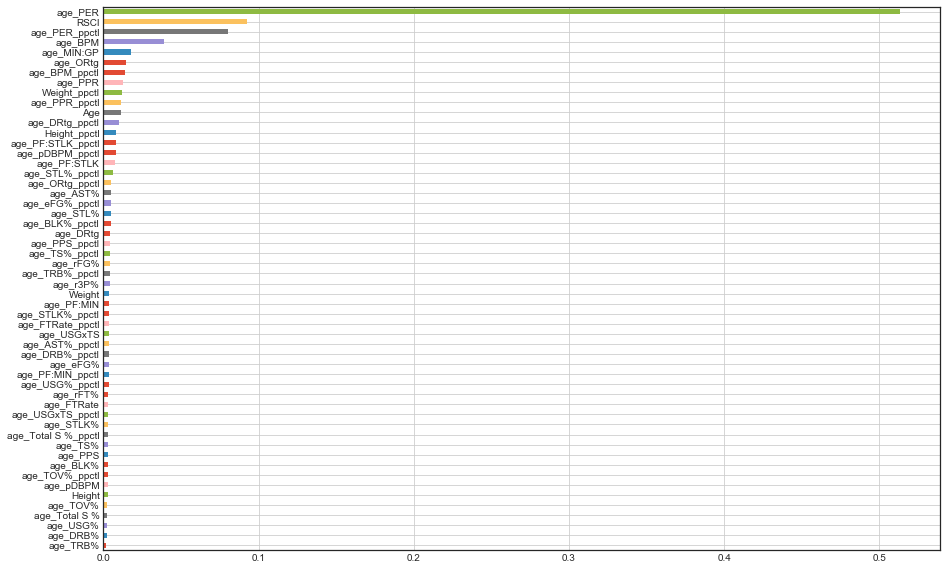

In [187]:
# Model selection process with cross validation.
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 
# run model 10x with 60/30 split intentionally leaving out 10%

#base model
rfr = ensemble.RandomForestRegressor(min_samples_leaf=7, min_samples_split=2, n_estimators=1500, n_jobs=-1, bootstrap=True, max_features='auto')
base_results = model_selection.cross_validate(rfr, ndf[x], ndf[y], cv=cv_split, n_jobs=-1)
rfr.fit(ndf[x], ndf[y])


print('BEFORE DT Parameters: ', rfr.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)

# Variable Strength
# Graph showing the relative importance of each variable on the final prediction of the model.
var_str = pd.Series(rfr.feature_importances_, index=x)
var_str.sort_values(inplace=True)
var_str.plot(kind='barh', grid=True)
plt.show()

In [188]:
new_x = var_str.reset_index()['index'].tolist()

### Feature Tuning

#First-Pass model
print('BEFORE DT RFE Training Shape Old: ', ndf[new_x[20:]].shape) 
print('BEFORE DT RFE Training Columns Old: ', ndf[new_x[20:]].columns.values)

print("BEFORE DT RFE Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT RFE Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT RFE Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print('-'*10)



#feature selection
rfr_rfe = feature_selection.RFECV(rfr, step = 1, cv = cv_split, n_jobs=-1)
rfr_rfe.fit(ndf[new_x[20:]], ndf[y])

#transform x&y to reduced features and fit new model
X_rfe = ndf[new_x[20:]].columns.values[rfr_rfe.get_support()]
rfe_results = model_selection.cross_validate(rfr, ndf[X_rfe], ndf[y], cv  = cv_split, n_jobs=-1)

#print(dtree_rfe.grid_scores_)
print('AFTER DT RFE Training Shape New: ', ndf[X_rfe].shape) 
print('AFTER DT RFE Training Columns New: ', X_rfe)

print("AFTER DT RFE Training w/bin score mean: {:.2f}". format(rfe_results['train_score'].mean()*100)) 
print("AFTER DT RFE Test w/bin score mean: {:.2f}". format(rfe_results['test_score'].mean()*100))
print("AFTER DT RFE Test w/bin score 3*std: +/- {:.2f}". format(rfe_results['test_score'].std()*100*3))
print('-'*10)

BEFORE DT RFE Training Shape Old:  (1100, 34)
BEFORE DT RFE Training Columns Old:  ['age_AST%_ppctl' 'age_USGxTS' 'age_FTRate_ppctl' 'age_STLK%_ppctl'
 'age_PF:MIN' 'Weight' 'age_r3P%' 'age_TRB%_ppctl' 'age_rFG%'
 'age_TS%_ppctl' 'age_PPS_ppctl' 'age_DRtg' 'age_BLK%_ppctl' 'age_STL%'
 'age_eFG%_ppctl' 'age_AST%' 'age_ORtg_ppctl' 'age_STL%_ppctl'
 'age_PF:STLK' 'age_pDBPM_ppctl' 'age_PF:STLK_ppctl' 'Height_ppctl'
 'age_DRtg_ppctl' 'Age' 'age_PPR_ppctl' 'Weight_ppctl' 'age_PPR'
 'age_BPM_ppctl' 'age_ORtg' 'age_MIN:GP' 'age_BPM' 'age_PER_ppctl' 'RSCI'
 'age_PER']
BEFORE DT RFE Training w/bin score mean: 82.31
BEFORE DT RFE Test w/bin score mean: 62.82
BEFORE DT RFE Test w/bin score 3*std: +/- 15.20
----------
AFTER DT RFE Training Shape New:  (1100, 26)
AFTER DT RFE Training Columns New:  ['age_USGxTS' 'age_FTRate_ppctl' 'age_r3P%' 'age_TRB%_ppctl'
 'age_TS%_ppctl' 'age_PPS_ppctl' 'age_BLK%_ppctl' 'age_eFG%_ppctl'
 'age_AST%' 'age_STL%_ppctl' 'age_PF:STLK' 'age_pDBPM_ppctl'
 'age_PF:STLK_

BEFORE DT Parameters:  {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 7, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1500, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
BEFORE DT Training w/bin score mean: 81.76
BEFORE DT Test w/bin score mean: 63.21
BEFORE DT Test w/bin score 3*std: +/- 14.67
BEFORE DT Test w/bin set score min: 57.00
----------


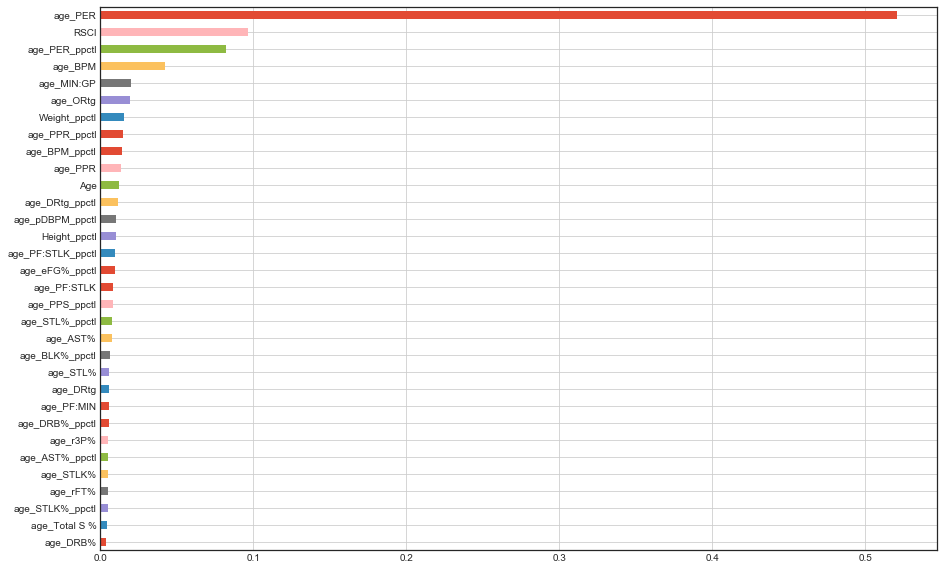

In [189]:
rfr_x = ['age_Total S %', 'age_rFT%', 'age_AST%_ppctl', 'age_PPS_ppctl',
 'age_DRB%_ppctl', 'age_eFG%_ppctl', 'age_DRB%', 'age_r3P%', 'age_STLK%',
 'age_STL%', 'Weight_ppctl', 'age_STLK%_ppctl', 'age_PF:MIN', 'Height_ppctl',
 'age_AST%', 'age_STL%_ppctl', 'age_ORtg', 'age_BLK%_ppctl', 'age_DRtg',
 'age_pDBPM_ppctl', 'age_PF:STLK_ppctl', 'age_PPR', 'age_PPR_ppctl',
 'age_PF:STLK', 'age_MIN:GP', 'Age', 'age_DRtg_ppctl', 'age_BPM',
 'age_BPM_ppctl', 'age_PER_ppctl', 'RSCI', 'age_PER']

# Model selection process with cross validation.
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 
# run model 10x with 60/30 split intentionally leaving out 10%

#base model
rfr = ensemble.RandomForestRegressor(min_samples_leaf=7, min_samples_split=2, n_estimators=1500, n_jobs=-1, bootstrap=True, max_features='auto')
base_results = model_selection.cross_validate(rfr, ndf[rfr_x], ndf[y], cv=cv_split, n_jobs=-1)
rfr.fit(ndf[rfr_x], ndf[y])


print('BEFORE DT Parameters: ', rfr.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)

# Variable Strength
# Graph showing the relative importance of each variable on the final prediction of the model.
var_str = pd.Series(rfr.feature_importances_, index=rfr_x)
var_str.sort_values(inplace=True)
var_str.plot(kind='barh', grid=True)
plt.show()

In [190]:
rfr_x = ['age_Total S %', 'age_rFT%', 'age_AST%_ppctl', 'age_PPS_ppctl',
 'age_DRB%_ppctl', 'age_eFG%_ppctl', 'age_DRB%', 'age_r3P%', 'age_STLK%',
 'age_STL%', 'Weight_ppctl', 'age_STLK%_ppctl', 'age_PF:MIN', 'Height_ppctl',
 'age_AST%', 'age_STL%_ppctl', 'age_ORtg', 'age_BLK%_ppctl', 'age_DRtg',
 'age_pDBPM_ppctl', 'age_PF:STLK_ppctl', 'age_PPR', 'age_PPR_ppctl',
 'age_PF:STLK', 'age_MIN:GP', 'Age', 'age_DRtg_ppctl', 'age_BPM',
 'age_BPM_ppctl', 'age_PER_ppctl', 'RSCI', 'age_PER']

# Model selection process with cross validation.
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 
# run model 10x with 60/30 split intentionally leaving out 10%

#base model
rfr = ensemble.RandomForestRegressor(min_samples_leaf=7, min_samples_split=2, n_estimators=1500, n_jobs=-1, bootstrap=True, max_features='auto')
base_results = model_selection.cross_validate(rfr, ndf[rfr_x], ndf[y], cv=cv_split, n_jobs=-1)
rfr.fit(ndf[rfr_x], ndf[y])

print('BEFORE DT Parameters: ', rfr.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)


#tune hyper-parameters: 
param_grid = {
                'n_estimators': [1500],
                'min_samples_split': [2],
                'min_samples_leaf': [7],
                'random_state': [2],
                'max_features': [10, 15, 20, 25, 'auto']
             }

#print(list(model_selection.ParameterGrid(param_grid)))

# choose best model with grid_search: 
tune_model = model_selection.GridSearchCV(rfr, param_grid=param_grid, cv=cv_split, n_jobs=-1)
tune_model.fit(ndf[rfr_x], ndf[y])

#print(tune_model.cv_results_.keys())
#print(tune_model.cv_results_['params'])
print('AFTER DT Parameters: ', tune_model.best_params_)
#print(tune_model.cv_results_['mean_train_score'])
print("AFTER DT Training w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_train_score'][tune_model.best_index_]*100)) 
#print(tune_model.cv_results_['mean_test_score'])
print("AFTER DT Test w/bin score mean: {:.2f}". format(tune_model.cv_results_['mean_test_score'][tune_model.best_index_]*100))
print("AFTER DT Test w/bin score 3*std: +/- {:.2f}". format(tune_model.cv_results_['std_test_score'][tune_model.best_index_]*100*3))
print('-'*10)

BEFORE DT Parameters:  {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 7, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1500, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
BEFORE DT Training w/bin score mean: 81.72
BEFORE DT Test w/bin score mean: 63.25
BEFORE DT Test w/bin score 3*std: +/- 14.89
BEFORE DT Test w/bin set score min: 56.87
----------
AFTER DT Parameters:  {'max_features': 20, 'min_samples_leaf': 7, 'min_samples_split': 2, 'n_estimators': 1500, 'random_state': 2}
AFTER DT Training w/bin score mean: 81.02
AFTER DT Test w/bin score mean: 63.51
AFTER DT Test w/bin score 3*std: +/- 14.53
----------


BEFORE DT Parameters:  {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 20, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 7, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1500, 'n_jobs': -1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
BEFORE DT Training w/bin score mean: 81.01
BEFORE DT Test w/bin score mean: 63.45
BEFORE DT Test w/bin score 3*std: +/- 14.47
BEFORE DT Test w/bin set score min: 57.36
----------


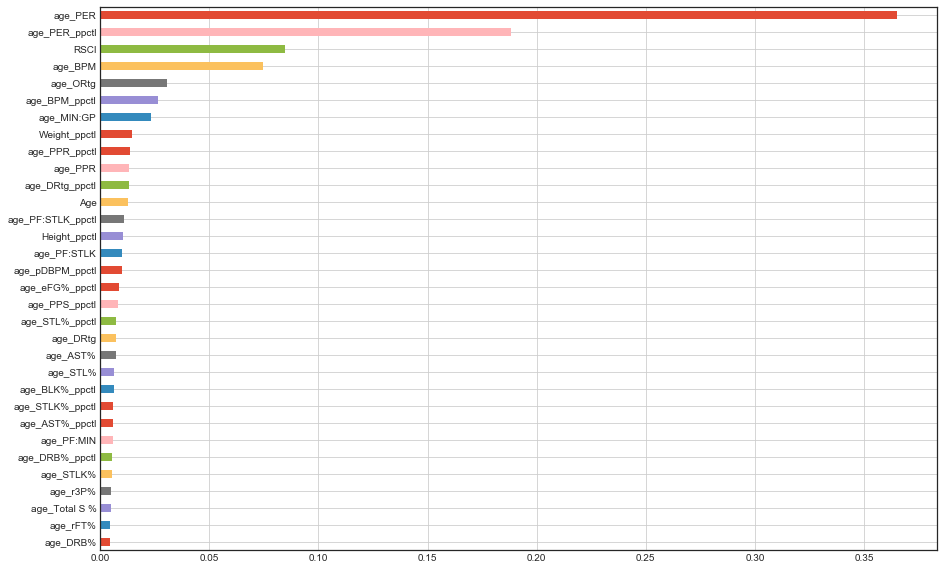

In [191]:
rfr_x = ['age_Total S %', 'age_rFT%', 'age_AST%_ppctl', 'age_PPS_ppctl',
 'age_DRB%_ppctl', 'age_eFG%_ppctl', 'age_DRB%', 'age_r3P%', 'age_STLK%',
 'age_STL%', 'Weight_ppctl', 'age_STLK%_ppctl', 'age_PF:MIN', 'Height_ppctl',
 'age_AST%', 'age_STL%_ppctl', 'age_ORtg', 'age_BLK%_ppctl', 'age_DRtg',
 'age_pDBPM_ppctl', 'age_PF:STLK_ppctl', 'age_PPR', 'age_PPR_ppctl',
 'age_PF:STLK', 'age_MIN:GP', 'Age', 'age_DRtg_ppctl', 'age_BPM',
 'age_BPM_ppctl', 'age_PER_ppctl', 'RSCI', 'age_PER']

# Model selection process with cross validation.
cv_split = model_selection.ShuffleSplit(n_splits = 10, test_size = .3, train_size = .6, random_state = 0 ) 
# run model 10x with 60/30 split intentionally leaving out 10%

#base model
rfr = ensemble.RandomForestRegressor(min_samples_leaf=7, min_samples_split=2, n_estimators=1500, n_jobs=-1, bootstrap=True, max_features=20)
base_results = model_selection.cross_validate(rfr, ndf[rfr_x], ndf[y], cv=cv_split, n_jobs=-1)
rfr.fit(ndf[rfr_x], ndf[y])

print('BEFORE DT Parameters: ', rfr.get_params())
print("BEFORE DT Training w/bin score mean: {:.2f}". format(base_results['train_score'].mean()*100)) 
print("BEFORE DT Test w/bin score mean: {:.2f}". format(base_results['test_score'].mean()*100))
print("BEFORE DT Test w/bin score 3*std: +/- {:.2f}". format(base_results['test_score'].std()*100*3))
print("BEFORE DT Test w/bin set score min: {:.2f}". format(base_results['test_score'].min()*100))
print('-'*10)

# Variable Strength
# Graph showing the relative importance of each variable on the final prediction of the model.
var_str = pd.Series(rfr.feature_importances_, index=rfr_x)
var_str.sort_values(inplace=True)
var_str.plot(kind='barh', grid=True)
plt.show()

In [192]:
import _pickle as cPickle
with open('RFDraftModelforDistrs3-8-18-Fill-6-Head-1100-MIN-50.cpickle-reg-season-final-data', 'wb') as f:
    cPickle.dump(rfr, f)

In [193]:
def multi_player_distr_plot(dataframe1, pids1, dataframe2, pids2):
    names = []
    distr_df = pd.DataFrame()
    
    for pid in pids1:
        pid_stats = dataframe1[rfr_x].loc[[pid]]
    
        forest = rfr.estimators_
        plyr_distr = [tree.predict(pid_stats)[0] for tree in forest]

        name = pid.split('/')[1]
        names.append(name)
        
        distr_df[name] = plyr_distr
        
    for pid in pids2:
        pid_stats = dataframe2[rfr_x].loc[[pid]]
    
        forest = rfr.estimators_
        plyr_distr = [tree.predict(pid_stats)[0] for tree in forest]

        name = pid.split('/')[1]
        names.append(name)
        
        distr_df[name] = plyr_distr
    
    for player in distr_df:
        ax = sns.kdeplot(distr_df[player], shade=True)
        ax.set(xlim=(-6 , 10), title='Career Peak PIPM Prediction Distributions', xlabel='Peak PIPM', ylabel='Fraction of Outcomes')
        ax.set_title('Career Peak PIPM Prediction Distributions')

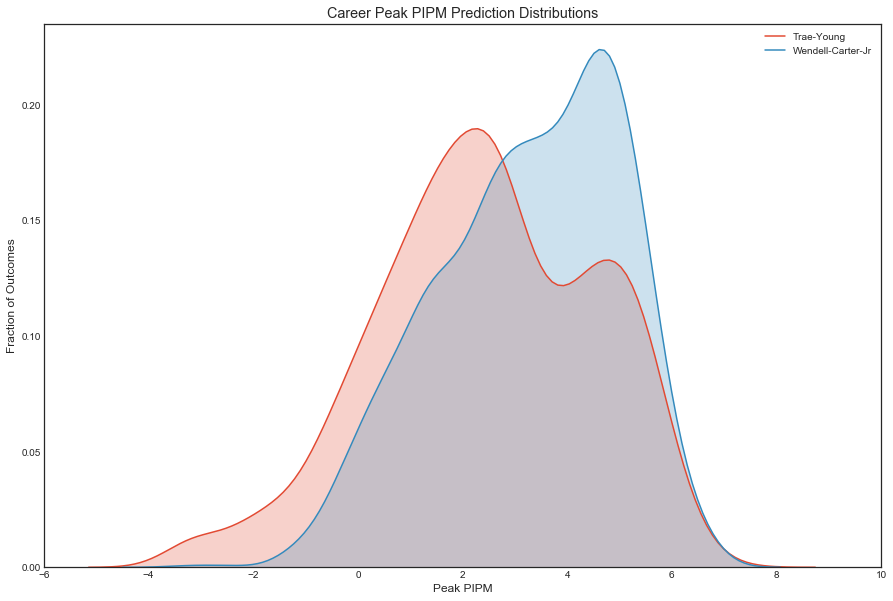

In [198]:
plyr_ids18 = ['/Trae-Young/Summary/88934', '/Wendell-Carter-Jr/Summary/76236']
plyr_ids = []
multi_player_distr_plot(df_18, plyr_ids18, ndf, plyr_ids)

In [195]:
ml_pred_df = pd.DataFrame()
ml_pred_df['Player'] = df_18.index.tolist()
ml_pred_df['Random Forest'] = rfr.predict(df_18[rfr_x])

ml_pred_df.to_csv('2018 PIPM Pred.csv', index=False)

In [197]:
players = df_18.index.tolist()
player_distributions = pd.DataFrame()

for player in players:
    pid_stats = df_18[rfr_x].loc[[player]]

    forest = rfr.estimators_
    plyr_distr = [tree.predict(pid_stats)[0] for tree in forest]

    name = player.split('/')[1]
    player_distributions[name] = plyr_distr

player_distributions

player_distributions.to_csv('2014-8RFTreesPerPlayer.csv')

(array([ 123.,  194.,  194.,  207.,  187.,  192.,  162.,  153.,  122.,
         121.,  101.,   69.,   86.,   70.,   68.,   82.,   54.,   68.,
          63.,   60.,   34.,   40.,   36.,   38.,   37.,   32.,   30.,
          16.,   18.,   13.,   14.,   10.,   10.,    9.,   19.,    6.,
           9.,    4.,    6.,    6.,    9.,    5.,    6.,    8.,    6.,
           3.,    2.,    4.,    2.,    2.]),
 array([ -5.99164485e+00,  -5.80454208e+00,  -5.61743930e+00,
         -5.43033652e+00,  -5.24323374e+00,  -5.05613096e+00,
         -4.86902819e+00,  -4.68192541e+00,  -4.49482263e+00,
         -4.30771985e+00,  -4.12061707e+00,  -3.93351430e+00,
         -3.74641152e+00,  -3.55930874e+00,  -3.37220596e+00,
         -3.18510318e+00,  -2.99800041e+00,  -2.81089763e+00,
         -2.62379485e+00,  -2.43669207e+00,  -2.24958929e+00,
         -2.06248652e+00,  -1.87538374e+00,  -1.68828096e+00,
         -1.50117818e+00,  -1.31407540e+00,  -1.12697263e+00,
         -9.39869849e-01,  -7.52767071e-01

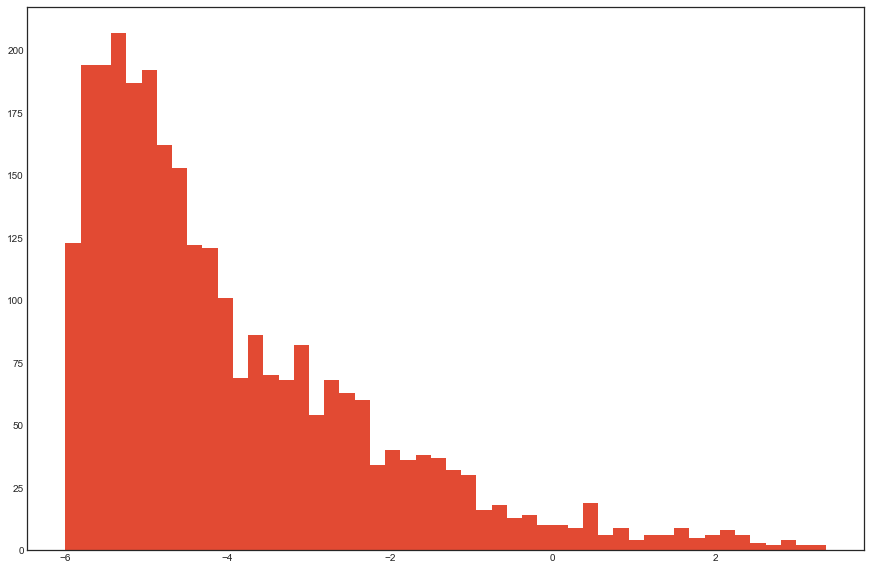

In [196]:
plt.hist(ml_pred_df['Random Forest'], 50)